In [1]:
# google colab specific - installing probcox
!pip3 install torch==1.7.0
!pip3 install pyro-ppl==1.5.1
!pip3 install probcox

     |████████████████████████████████| 776.7 MB 4.0 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.7.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.7.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.7.0 which is incompatible.
     |████████████████████████████████| 607 kB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for probcox: filename=probcox-0.0.5-py3-none-any.whl size=5224 sha256=b26371c04c33e18ffc324e5bde75c2e3d9875d0510b6a8

In [2]:
# Modules
# =======================================================================================================================
import os
import sys
import time
import shutil
import subprocess
import tqdm

import numpy as np
import pandas as pd

import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist

from pyro.infer import SVI, Trace_ELBO

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import probcox as pcox

dtype = torch.FloatTensor

# Set Seed
np.random.seed(34456)
torch.manual_seed(2342)

In [3]:

# custom functions
# -----------------------------------------------------------------------------------------------------------------------------

def forward_fill(x):
    for ii in range(1, x.shape[0]):
        if np.sum(x[ii, :]) == 0:
            x[ii, :] = x[ii-1, :]
    return(x)

def logisitc(x):
    return(1/(1+np.exp(-x)))

def logit(x):
    return(np.log(x/(1-x)))

# 
# -----------------------------------------------------------------------------------------------------------------------------

class TVC():
    def __init__(self, theta=None, P_binary=None, P_continuous=None,  p_binomial=0.35, sigma_normal=1, cholesky=None, dtype=dtype):
        self.theta = theta
        self.P_binary = P_binary
        self.P_continuous = P_continuous
        self.P = P_binary + P_continuous
        self.dtype = dtype
        self.p_binomial = p_binomial
        self.sigma_normal = sigma_normal
        
        # define correlation 
        self.L = cholesky
        
        super().__init__()

    def make_lambda0(self, scale):
        tsum = 0
        t_lambda = [0]
        psum = 0
        basehaz = [10e-5]
        while tsum < 30000:
            t_lambda.append(np.minimum(30000, t_lambda[-1] + np.round(np.random.gamma(4, 200)).astype(int)))
            if t_lambda[-1] <= 15000:
                basehaz.append(basehaz[-1] + np.random.gamma(2, 1))
            elif np.logical_and(t_lambda[-1] > 15000, t_lambda[-1] <= 25000):
                basehaz.append(basehaz[-1] + np.random.gamma(1, 10))
            else:
                basehaz.append(basehaz[-1] - np.random.gamma(1, 5))
            if basehaz[-1] <= 0:
                basehaz[-1] = 10
            psum += basehaz[-2] * (t_lambda[-1] - t_lambda[-2])
            tsum = t_lambda[-1]
        t_lambda = np.asarray(t_lambda)
        basehaz = np.asarray(basehaz)[:, None]
        basehaz = basehaz / (psum*scale)
        self.t_lambda0, self.lambda0, self.logit_lambda0 = t_lambda, basehaz, logit(basehaz)

    def return_lambda0(self):
        return(self.t_lambda0, self.lambda0)

    def sample(self):
        EOO = np.round(np.random.uniform(1000, 30000)).astype(int)
        # sample covariates:
        tsum = 0
        t_cov = [0]
        
        X = np.zeros((1, self.P_binary + self.P_continuous))
        while tsum < EOO:
            t_cov.append(np.minimum(EOO, t_cov[-1] + np.round(np.random.gamma(4, 500)).astype(int)))
            X_ = np.random.normal(0, 1, (1, self.P))
            X_ = np.matmul(X_, self.L.T)
            X = np.concatenate((X, X_))
            tsum = t_cov[-1]
        t_cov = np.asarray(t_cov)

        # combine with baseline hazard
        basehaz = np.copy(self.logit_lambda0)

        #expand
        basehaz = np.concatenate((basehaz, np.zeros((t_cov.shape[0], 1))))
        X = np.concatenate((np.zeros((self.t_lambda0.shape[0], self.P_binary + self.P_continuous)), X))
        t = np.concatenate((self.t_lambda0, t_cov))
        idx_sort = np.argsort(t)
        t = t[idx_sort]
        basehaz = forward_fill(basehaz[idx_sort])
        X = forward_fill(X[idx_sort])

        idx_r = (t <= EOO)
        t = t[idx_r]
        basehaz = basehaz[idx_r]
        X = X[idx_r]

        # collapse
        X = np.concatenate([np.sum(X[t==ii, :], axis=0)[None, :] for ii in np.unique(t)])
        basehaz = np.concatenate([np.sum(basehaz[t==ii, :], axis=0)[None, :] for ii in np.unique(t)])
        t = np.unique(t)

        # survial data
        H = logisitc(np.matmul(X, self.theta) + basehaz)
        t_diff = (t[1:] - t[:-1])
        event = False

        for ii in range(H.shape[0]-1):
            eval = np.random.uniform(0, 1, (t_diff[ii],)) <= H[ii]
            if np.any(eval):
                event = True
                break
        if event:
            t_event = np.maximum(1, np.where(eval)[0][0])
            X = X[:ii+1]
            t = t[:ii+1]
            t = np.concatenate((t, np.asarray([t[-1] + t_event])))
            time = np.concatenate((t[:-1, None], t[1:, None], np.zeros((X.shape[0], 1))), axis=1)
            time[-1, -1] = 1
        else:
            time = np.concatenate((t[:-1, None], t[1:, None], np.zeros((X.shape[0]-1, 1))), axis=1)
            X = X[:-1]

        # collapse - times by unique covariate shifts
        idx_keep = []
        for ll in range(time.shape[0]-1, 0, -1):
            if np.all(X[ll, :] == X[ll-1, :]):
                idx_keep.append([False])
                time[ll-1, 1] = time[ll, 1]
                time[ll-1, -1] = time[ll, -1]
            else:
                idx_keep.append([True])
        idx_keep.append([True])
        idx_keep = np.asarray(idx_keep)[:, 0]
        idx_keep = np.flip(idx_keep)

        time = time[idx_keep, :]
        X = X[idx_keep, :]

        return(torch.tensor(time).type(self.dtype), torch.tensor(X).type(self.dtype))


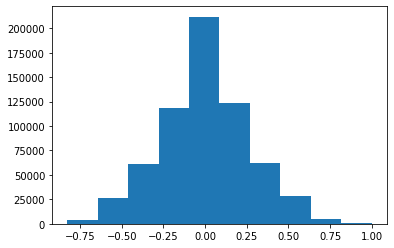

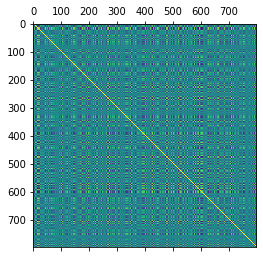

100%|██████████| 10000/10000 [07:54<00:00, 21.07it/s]

Obs:  61181
Censorship:  0.5176000000000001


In [4]:
# Simulation Settings
# =======================================================================================================================

I = 10000 # Number of Individuals
P_binary = 0
P_continuous = 800
P = P_binary + P_continuous
theta = np.random.normal(0, 0.75, 25)[:, None]
theta = np.concatenate((np.zeros((P_continuous-25, 1)), theta))
scale = 10  # Scaling factor for Baseline Hazard

# Correlation Matrix
n = P
a =  0.75
A = np.matrix([np.random.randn(n) + np.random.randn(1)*a for i in range(n)])
A = A*np.transpose(A)
D_half = np.diag(np.diag(A)**(-0.5))
C = D_half*A*D_half
L = np.linalg.cholesky(C)
vals = list(np.array(C.ravel())[0])
plt.hist(vals)
plt.show()
plt.close()
plt.matshow(C)
plt.show()
plt.close()

# Simulation
# =======================================================================================================================
# Class for simulation
TVC_corr = TVC(theta=theta, P_binary=P_binary, P_continuous=P_continuous, cholesky=L, dtype=dtype)

# Sample baseline hazard - scale is set to define censorship/events
TVC_corr.make_lambda0(scale=scale)

# Sample Data
run_id=1 # change for different dataset 1-5
np.random.seed(run_id)
torch.manual_seed(run_id)
surv = torch.zeros((0, 3))
X = torch.zeros((0, P))
for __ in tqdm.tqdm(range(I)):
    a, b = TVC_corr.sample()
    surv = torch.cat((surv, a))
    X = torch.cat((X, b))

total_obs = surv.shape[0]
total_events = torch.sum(surv[:, -1] == 1).numpy().tolist()
print('Obs: ', total_obs)
print('Censorship: ', 1-total_events/I)

In [5]:
# Inference Setup
# =======================================================================================================================
# Custom linear predictor - Here: simple linear combination
def predictor(data):
    theta =  pyro.sample("theta", dist.StudentT(1, loc=0, scale=0.001).expand([data[1].shape[1], 1])).type(dtype)
    pred = torch.mm(data[1], theta)
    return(pred)

def evaluate(surv, X, rank, batchsize, sampling_proportion, iter_, run_suffix, predictor=predictor):
    sampling_proportion[1] = batchsize
    eta=1 # paramter for optimization
    run = True # repeat initalization if NAN encounterd while training - gauge correct optimization settings
    while run:
        run = False
        pyro.clear_param_store()
        m = pcox.PCox(sampling_proportion=sampling_proportion, predictor=predictor)
        m.initialize(eta=eta, rank=rank, num_particles=3)
        loss=[0]
        for ii in tqdm.tqdm(range((iter_))):
            idx = np.unique(np.concatenate((np.random.choice(np.where(surv[:, -1]==1)[0], 1, replace=False), np.random.choice(range(surv.shape[0]), batchsize, replace=False))))[:batchsize]
            data=[surv[idx], X[idx]] # subsampled data
            loss.append(m.infer(data=data))
            # divergence check
            if loss[-1] != loss[-1]:
                eta = eta * 0.1
                run=True
                break
    g = m.return_guide()
    out = g.quantiles([0.025, 0.5, 0.975])
    return(out)

In [6]:
start_time = time.time()
pyro.clear_param_store()
out = evaluate(run_suffix='', rank=10, batchsize=512, iter_=25000, surv=surv, X=X, sampling_proportion=[total_obs, None, total_events, None])
print("--- %s seconds ---" % (time.time() - start_time))
theta_iden = np.sign(out['theta'][0].detach().numpy()) == np.sign(out['theta'][2].detach().numpy())

100%|██████████| 25000/25000 [17:34<00:00, 23.71it/s]

--- 1055.6780922412872 seconds ---


# R evaluation

In [7]:
# prepare data frame to sent to R
rd = pd.DataFrame(np.concatenate((surv.numpy(), X.numpy()), axis=1))
rd.columns = ['V' + str(ii) for ii in range(1, rd.shape[1]+1)]

rd_theta = pd.DataFrame(theta)
rd_theta.columns = ['V0']

In [8]:
# load R 
%load_ext rpy2.ipython

In [9]:
# install packages
%%R 
install.packages('survival')
install.packages('glmnet')
install.packages('devtools')
library(devtools)
install_github("michaelyanwang/dcalasso")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/survival_3.3-1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 6577371 bytes (6.3 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wr

* checking for file ‘/tmp/RtmpPfqsMR/remotes3a664ddd34/michaelyanwang-dcalasso-3574e07/DESCRIPTION’ ... OK
* preparing ‘dcalasso’:
* checking DESCRIPTION meta-information ... OK
* cleaning src
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘dcalasso_0.1.0.tar.gz’



R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [11]:
%%R -i rd -i theta -o beta_hat

set.seed(13)
library(glmnet)
library(survival)
library(dcalasso)

# dcalasso
start_time <- Sys.time()
mod = dcalasso(as.formula(paste0('Surv(V1,V2,V3)~',paste(paste0('V',4:803),collapse='+'))), family = 'cox.ph', data=rd, K = 2, iter.os = 4, ncores = 2)   
end_time <- Sys.time()
a <- unname(mod$coefficients.pen)
print(end_time - start_time)
beta_hat <- unname(mod$coefficients.pen)

Time difference of 15.56225 mins


In [12]:
print('R: ', (np.abs(theta[-25:]-beta_hat[-25:])).mean())
print('ProbCox: ', (np.abs(theta[-25:]-out['theta'][1].detach().numpy()[-25:, 0])).mean())
print('R - TP:', (beta_hat[-25:] != 0).sum(), ', FP: ', (beta_hat[:-25] != 0).sum())
print('ProbCox - TP:', theta_iden[-25:].sum(), ', FP: ', theta_iden[:-25].sum())

R:  0.8879360086007863
ProbCox:  0.8619667363230638
R - TP: 23 , FP:  221
ProbCox - TP: 23 , FP:  6
